In [168]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

In [169]:
start = pd.to_datetime('2010-08-01')
end = pd.to_datetime('2018-08-01')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
dates = data.index
columns = data.columns
data.index.name = "Date" #add date as column
data.reset_index(inplace = True)
data.index.name = "timeT" #add time as column
data.reset_index(inplace = True)
print(data.head())


[*********************100%***********************]  1 of 1 completed
   timeT       Date       Open       High        Low      Close  Adj Close   
0      0 2010-08-02  12.179100  12.285949  12.128041  12.214467  12.214467  \
1      1 2010-08-03  12.216709  12.265526  12.123558  12.200021  12.200021   
2      2 2010-08-04  12.258552  12.627668  12.230407  12.610732  12.610732   
3      3 2010-08-05  12.600022  12.667519  12.541990  12.655066  12.655066   
4      4 2010-08-06  12.587818  12.596286  12.354941  12.458801  12.458801   

      Volume  
0   74626675  
1   72362219  
2  153071607  
3   97178890  
4  133277692  


<Axes: >

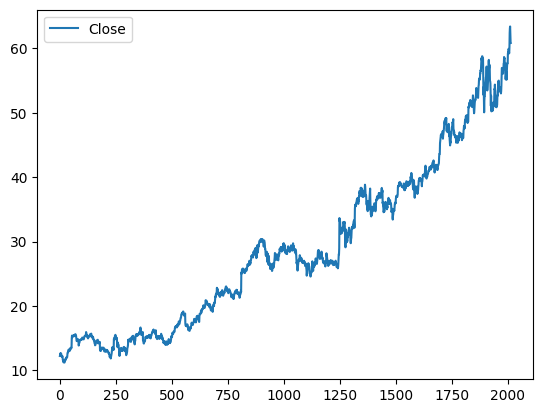

In [170]:
seaborn.lineplot(data.loc[:,["Close"]]) #plot the value of close

In [171]:
##first let us fit log(Y) = t + c, with Y value of the stock and t the time and c some constant
PF = np.polyfit(data.loc[:,"timeT"], np.log(data.loc[:,"Close"]), 1)
PF

array([7.73550822e-04, 2.48303867e+00])

In [172]:
#use the estimates to calculate the curve
dfTrySomething = data.loc[:,["Close", "timeT"]]
dfTrySomething["Estimate"] = np.exp(PF[0]*dfTrySomething["timeT"]+PF[1])
dfTrySomething["NoExp"] = dfTrySomething["Close"]/dfTrySomething["Estimate"] ##devide by trend

<Axes: ylabel='NoExp'>

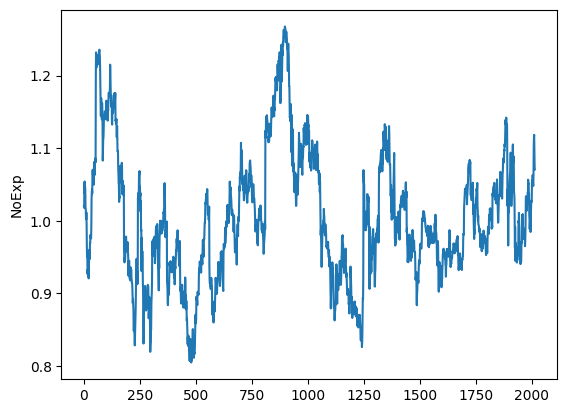

In [173]:
# plot the line with the trend removed
seaborn.lineplot((dfTrySomething.loc[:,"NoExp"]))

<Axes: >

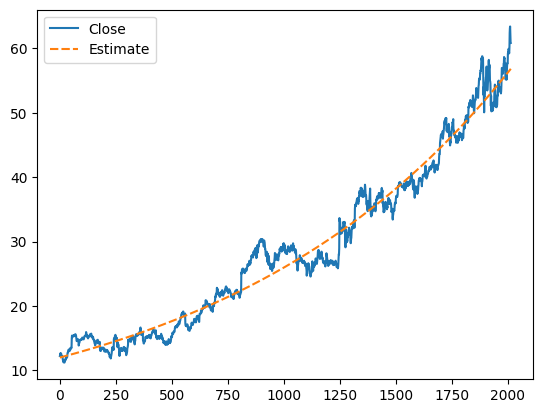

In [179]:
seaborn.lineplot(dfTrySomething.loc[:,["Close","Estimate"]])

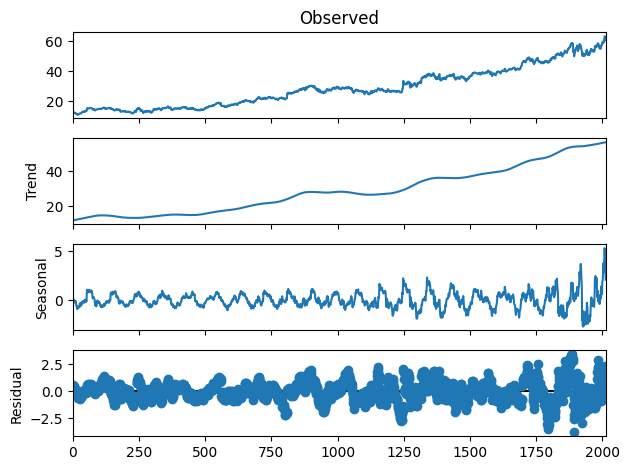

In [174]:
##something we did not full understand. Something with seasonality, however above doesnt nescessary show seasonality

from statsmodels.tsa.seasonal import STL

closeFrame = dfTrySomething.loc[:,"Close"]
closeFrame.index = [i for i in range(closeFrame.shape[0])]

res = STL(np.array(closeFrame), period=90).fit()
fig = res.plot()

ADF Statistic: -3.8346622138506294
p-value: 0.002571932849215208


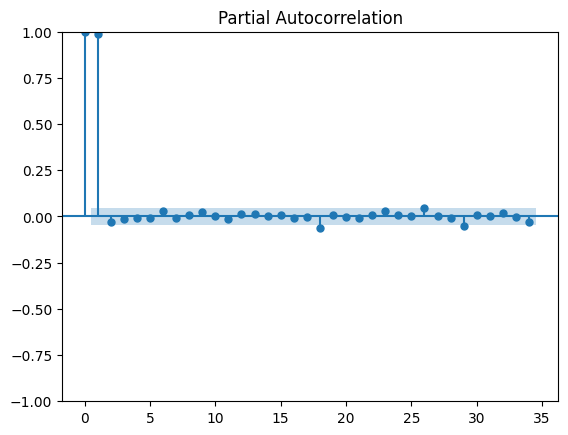

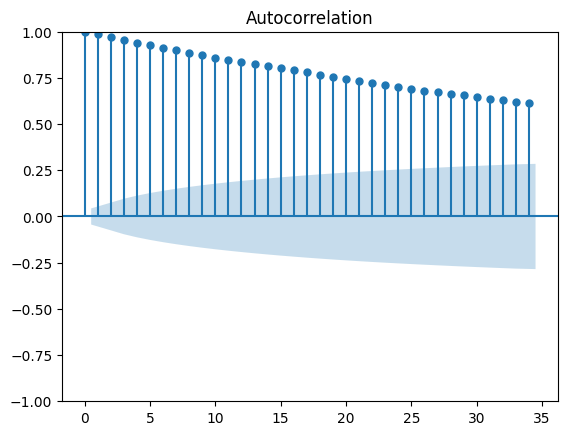

In [175]:
#needed for ARMA model
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


plot_pacf(dfTrySomething['NoExp'].dropna());
plot_acf(dfTrySomething['NoExp'].dropna());

ad_fuller_result = adfuller(dfTrySomething['NoExp'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [6]:
x_train = []
y_train = []

#time step: number of preceeding data points to be taken into account
time_step = 3

#iterate over the data
for i in range(time_step, data.shape[0]):
    #create a partition of the 3 preceeding data points
    x_train.append(data[i - time_step:i])

    #append the next days close price to the label array
    y_train.append(data[i, 3])